In [16]:
import pandas as pd
import numpy as np

import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib import cm

import io, base64
import os, sys
from datetime import datetime

import IPython
import pickle

from sklearn.utils import shuffle
import string

from tensorflow.keras.utils import Sequence

import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, AddBackgroundNoise, PitchShift, Shift, ClippingDistortion, Gain, LoudnessNormalization, TimeStretch 
from tensorflow.python.ops import gen_audio_ops as contrib_audio

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Flatten
from tensorflow.keras.layers import Dense, Dropout, Softmax
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model

from keras import backend as K 

import random 
import glob

from tensorflow.keras.models import load_model

import scipy.io.wavfile as wav

DEBUG = False

train_dataset_path = '../data/csv/train_data.csv'
valid_dataset_path = '../data/csv/valid_data.csv'
#test_dataset_path = '../data/csv/test_data.csv'
test_dataset_path = '../data/csv/wt_data.csv'

SAMPLING_RATE = 16000
MIN_FREQ = 100
MAX_FREQ = SAMPLING_RATE//2
WIN_SIZE_MS = 0.02
WIN_INCREASE_MS = 0.02
NUM_CEPSTRAL = 10

In [7]:
test_data = pd.read_csv(test_dataset_path)

In [8]:
test_data.head()

,Unnamed: 0,path,speakerId,transcription,action,object,location
0,0,wavs/wt_data/Bring_me_my_socks_325311.wav,NaN,Bring me my socks,bring,socks,none
1,1,wavs/wt_data/Bring_me_my_socks_872611.wav,NaN,Bring me my socks,bring,socks,none
2,2,wavs/wt_data/Bring_me_some_juice_147104.wav,NaN,Bring me some juice,bring,juice,none
3,3,wavs/wt_data/Bring_me_some_juice_184605.wav,NaN,Bring me some juice,bring,juice,none
4,4,wavs/wt_data/Bring_me_some_juice_336204.wav,NaN,Bring me some juice,bring,juice,none


In [9]:
prefix = ["..", "data"]
wav_file = os.path.join(*prefix, test_data['path'][0])
print(wav_file)
IPython.display.Audio(wav_file)

../data/wavs/wt_data/Bring_me_my_socks_325311.wav


2021-08-24 16:57:39.078401: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-24 16:57:39.156323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-24 16:57:39.156837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.683GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2021-08-24 16:57:39.156893: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-24 16:57:39.380542: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-24 16:57:39.380808: I tensorflow/stream_executor/platform/d

{'type': 'spectrogram', 'shape': {'width': 10, 'height': 150}}


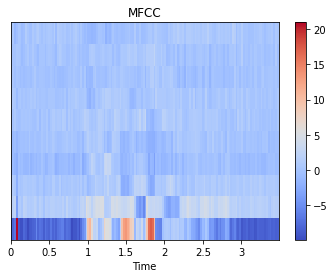

In [11]:
audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')

if DEBUG:
    print(wav_file)

def generate_features(draw_graphs, raw_data, sampling_freq,
                      frame_length, frame_stride, num_filters, 
                      num_cepstral, low_frequency, high_frequency):
    graphs = []
    
    raw_data = np.expand_dims(raw_data, axis = -1)
    window_size = int(sampling_freq * frame_length)
    stride = int(sampling_freq * frame_stride)
    
    spectrogram = contrib_audio.audio_spectrogram(
        raw_data,
        window_size=window_size,
        stride=stride,
        magnitude_squared=True)
    
    mfcc = contrib_audio.mfcc(
        spectrogram,
        sampling_freq,
        dct_coefficient_count=num_cepstral,
        upper_frequency_limit=high_frequency, 
        lower_frequency_limit=low_frequency)
    
    mfcc = np.squeeze(mfcc)

    if draw_graphs:
        mfcc_graph = np.swapaxes(mfcc, 0, 1)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(mfcc_graph, x_axis='time', ax=ax)
        fig.colorbar(img, ax=ax)
        ax.set(title='MFCC')
        buf = io.BytesIO()

        plt.savefig(buf, format='svg', bbox_inches='tight', pad_inches=0)

        buf.seek(0)
        image = (base64.b64encode(buf.getvalue()).decode('ascii'))

        buf.close()

        graphs.append({
            'name': 'Cepstral Coefficients',
            'image': image,
            'imageMimeType': 'image/svg+xml',
            'type': 'image'
        })

    return {
        'features': mfcc,
        'graphs': graphs,
        'output_config': {
            'type': 'spectrogram',
            'shape': {
                'width': mfcc.shape[1],
                'height': mfcc.shape[0]
            }
        }
    }

processed = generate_features(True, audio, SAMPLING_RATE, 
                              WIN_SIZE_MS, WIN_INCREASE_MS, 32, 
                              NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

if DEBUG:
    print(processed['features'])
    
print(processed['output_config'])

In [12]:
class DatasetFactory:
    
    def __init__(self):
        self.actions = set()
        self.objects = set()
        self.locations = set()
        self.vocab = set()
    
    def get_query_slots(self, sentence):

        slots = [sentence[0], sentence[1]]
        return slots      
    
    def get_properties(self, data):

        data["action"] = data['action'].str.lower()
        data["object"] = data['object'].str.lower()
        data["location"] = data['location'].str.lower()

        actions = set(data.action.unique())
        objects = set(data.object.unique())
        locations = set(data.location.unique())

        return actions, objects, locations        

    def get_vocab(self, actions, objects, locations, data):

        vocab = objects | locations

        if DEBUG:
            print(vocab)

        data["transcription"] = data['transcription'].str.replace('[^\w\s]','')
        data["transcription"] = data['transcription'].str.lower()

        for item in data.transcription:
            for word in item.split(" "):
                vocab.add(word)

        vocab = [s.strip() for s in vocab]
        
        return set(vocab)   
    
    def add_corpora(self, data):
        
        actions, objects, locations = self.get_properties(data)
        vocab = self.get_vocab(actions, objects, locations, data)

        self.actions = set(self.actions | actions)
        self.objects = set(self.objects | objects)
        self.locations = set(self.locations | locations)        
        self.vocab = set(self.vocab | vocab)  
        self.query_slots = set(self.objects | self.locations)
        
    def process_data(self, data):
        
        self.actions = list(self.actions)
        self.objects = list(self.objects)
        self.locations = list(self.locations)       
        self.vocab = list(self.vocab)
        self.query_slots = list(self.query_slots)
        
        word_ids, slot_ids, intent_ids = {' ': 0}, {}, {self.actions[i]: i for i in range(0, len(self.actions))}

        slots = []
        for sentence in zip(data.object, data.location):
            slots.append(self.get_query_slots(sentence))
        
        i = 0
        for slot in self.query_slots:
            if slot == 'none':
                continue
            slot_ids[slot] = i
            i += 1
            
        slot_ids['none'] = i

        #convert vocab to dictionary
        start = 1
        for i in range(len(self.vocab)):
            word_ids[self.vocab[i]] = start + i
        word_ids['unknown'] =  i + 1  

        #create reverse dicts
        ids2words = dict((v, k) for k, v in word_ids.items())
        ids2slots = dict((v, k) for k, v in slot_ids.items())
        ids2intents = dict((v, k) for k, v in intent_ids.items())

        n_vocab = len(ids2words)

        n_classes = len(ids2intents)
        n_slots = len(ids2slots)

        vectorized_slots = list(map(lambda slots: np.array(list(map(lambda slot: slot_ids[slot], slots))), slots))
        vectorized_intents = list(map(lambda l: np.array([intent_ids[l]]), data.action))

        filepaths = data['path'].to_numpy()

        return ids2intents, ids2slots, vectorized_slots, vectorized_intents, filepaths        
    
def save_obj(obj, name):
    with open('../data/pkl/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('../data/pkl/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

generate_data = False

train_data = pd.read_csv(train_dataset_path)
valid_data = pd.read_csv(valid_dataset_path)
test_data = pd.read_csv(test_dataset_path)

if generate_data:
    
    dataset_processor = DatasetFactory()
    
    train_data = pd.read_csv(train_dataset_path)
    valid_data = pd.read_csv(valid_dataset_path)
    test_data = pd.read_csv(test_dataset_path)
    
    dataset_processor.add_corpora(train_data)
    dataset_processor.add_corpora(valid_data)
    dataset_processor.add_corpora(test_data)
    
    ids2intents, ids2slots, vectorized_slots_train, vectorized_intents_train, filepaths_train = dataset_processor.process_data(train_data)
    _ids2intents, _ids2slots, vectorized_slots_valid, vectorized_intents_valid, filepaths_valid = dataset_processor.process_data(valid_data)
    __ids2intents, __ids2slots, vectorized_slots_test, vectorized_intents_test, filepaths_test = dataset_processor.process_data(test_data)

    assert ids2intents == _ids2intents == __ids2intents
    assert ids2slots == _ids2slots == __ids2slots
    
    save_obj(ids2intents, 'ids2intents')
    save_obj(ids2slots, 'ids2slots')
    
    save_obj(vectorized_slots_train, 'vectorized_slots_train')
    save_obj(vectorized_intents_train, 'vectorized_intents_train')
    
    save_obj(vectorized_slots_valid, 'vectorized_slots_valid')
    save_obj(vectorized_intents_valid, 'vectorized_intents_valid')
    
    save_obj(vectorized_slots_test, 'vectorized_slots_test')
    save_obj(vectorized_intents_test, 'vectorized_intents_test') 
    
else:

    filepaths_train = train_data['path'].to_numpy()
    filepaths_valid = valid_data['path'].to_numpy()
    filepaths_test = test_data['path'].to_numpy()
    
    ids2intents = load_obj('ids2intents')
    ids2slots = load_obj('ids2slots')
    
    vectorized_slots_train = load_obj('vectorized_slots_train')
    vectorized_intents_train = load_obj('vectorized_intents_train')
    
    vectorized_slots_valid = load_obj('vectorized_slots_valid')
    vectorized_intents_valid = load_obj('vectorized_intents_valid')
    
    vectorized_slots_test = load_obj('vectorized_slots_test')
    vectorized_intents_test = load_obj('vectorized_intents_test')
    
if DEBUG:
    print(vectorized_slots_test)
    print(vectorized_intents_test)
    print(ids2intents) 
    print(ids2slots) 

print(str(ids2intents.values()).replace("'", "\"")) 
print(str(ids2slots.values()).replace("'", "\"")) 

n_classes = len(ids2intents)
n_slots = len(ids2slots)    

dict_values(["decrease", "activate", "change language", "bring", "deactivate", "increase"])
dict_values(["juice", "english", "lights", "washroom", "socks", "heat", "volume", "chinese", "shoes", "lamp", "korean", "bedroom", "music", "german", "kitchen", "newspaper", "none"])


In [14]:
def create_aug_pipeline():
    
    aug_pipeline = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.1),
    AddBackgroundNoise(sounds_path="../data/wavs/background_noise", p=0.3),
    ClippingDistortion(p=0.3),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.2),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.1),
    Gain(p=0.2),
    TimeStretch(p=0.05)
    ])
    
    return aug_pipeline

class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, entries, num_list, batch_size, shuffle=True, to_fit=True, augment = True, vis = False):

        self.entries = entries
        self.batch_size = batch_size
        
        self.n_intents, self.n_slots = num_list
        
        self.len = 2
        self.aug_pipeline = None
        if augment:
            self.aug_pipeline = create_aug_pipeline()
        self.vis = vis
        self.shuffle = shuffle
        self.to_fit = to_fit
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.entries[0]) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        X_batch = [self.entries[0][k] for k in indexes]
        
        Y_intent = [self.entries[1][k] for k in indexes]
        Y_slot = [self.entries[2][k] for k in indexes]
        
        # Generate data
        X = self._generate_X(X_batch)

        if self.to_fit:
            y = self._generate_y(Y_intent, Y_slot)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.entries[0]))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, batch_items):

        X = np.zeros(shape = (self.batch_size, 150, NUM_CEPSTRAL, 1))
         
        for i, batch_item in enumerate(batch_items):
            wav_file = os.path.join(*prefix, batch_item)
            audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')
            audio = librosa.util.fix_length(audio, 16000*3)
            
            if self.aug_pipeline:
                audio = self.aug_pipeline(audio, sample_rate)
                
                if DEBUG:
                    new_filename = os.path.join('samples', os.path.basename(batch_item.split('.')[0]+'aug.wav'))
                    print("Augmented: ", new_filename)
                    print("--------------")
                    sf.write(new_filename, audio, sample_rate,  subtype='PCM_16')
                
            output = generate_features(self.vis, audio, SAMPLING_RATE, 
                                          WIN_SIZE_MS, WIN_INCREASE_MS, 32, 
                                          NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

            features = output['features']
            X[i, ] = np.expand_dims(features, axis = -1)
        return X
    
    def _generate_y(self, intents, slots):
        intent_y = np.empty((self.batch_size, self.n_intents), dtype=int)
        slot_y = np.empty((self.batch_size, self.len, self.n_slots), dtype=int)      

        # Generate data
        for i, batch_item in enumerate(intents):
            intent = intents[i]
            slot = slots[i]
            intent_y[i,] = np.eye(self.n_intents)[intent]
            slot_y[i,] = np.eye(self.n_slots)[slot][np.newaxis, :]
        
        return [intent_y, slot_y]

batch_size = 32   
    
training_generator = DataGenerator([filepaths_train, vectorized_intents_train, vectorized_slots_train], 
                                   [n_classes,n_slots], batch_size = batch_size, 
                                   shuffle=True, to_fit=True, augment = True)

data = training_generator.__getitem__(0)
print(data[0].shape)
print(data[1][0].shape)
print(data[1][1].shape)
print(training_generator.__len__())

validation_generator = DataGenerator([filepaths_valid, vectorized_intents_valid, vectorized_slots_valid], 
                                     [n_classes,n_slots], batch_size = batch_size, 
                                     shuffle=False, to_fit=True, augment = False)


data = validation_generator.__getitem__(0)
print(data[0].shape)
print(data[1][0].shape)
print(data[1][1].shape)
print(validation_generator.__len__())

test_generator = DataGenerator([filepaths_test, vectorized_intents_test, vectorized_slots_test], 
                                     [n_classes, n_slots], batch_size = batch_size, vis = False,
                                     shuffle=False, to_fit=True, augment = False)

data = test_generator.__getitem__(0)
print(data[0].shape)
print(data[1][0].shape)
print(data[1][1].shape)
print(test_generator.__len__())

(32, 150, 10, 1)
(32, 6)
(32, 2, 17)
722
(32, 150, 10, 1)
(32, 6)
(32, 2, 17)
97
(32, 150, 10, 1)
(32, 6)
(32, 2, 17)
5


In [15]:
K.clear_session()

main_input = Input(shape=(150, NUM_CEPSTRAL, 1), name='main_input')

x = Conv2D(16, 3, padding='same', activation='relu', use_bias = False)(main_input)
x = BatchNormalization()(x)

x = Conv2D(16, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(16, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(32, 3, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(128, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)

x = GlobalMaxPooling2D()(x)

x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)

slot_dense = Dense(n_slots*2)(x)
slot_reshape = Reshape(target_shape = (2, n_slots))(slot_dense)
slot_output = Softmax(name='slot_output')(slot_reshape)

intent_output = Dense(n_classes, activation='softmax', name='intent_output', use_bias = False)(x)

model = Model(inputs=main_input, outputs=[intent_output, slot_output])

optim = Adam(learning_rate=1e-3)

model.compile(optimizer = optim, loss='categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 150, 10, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 10, 16)  144         main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 10, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 10, 16)  1024        batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
output_path = os.path.join("..", "checkpoints", datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.mkdir(output_path)
print("Project folder: {}".format(output_path))

model_name = os.path.join(output_path, "slu_model.h5")
                           
my_callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True, verbose = 1),
    ModelCheckpoint(filepath=model_name, save_best_only=True, verbose = 1),
    TensorBoard(log_dir='./logs'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose = 1)]
try:
    model.fit(training_generator, validation_data = test_generator,
              callbacks = my_callbacks, epochs=10, 
              workers = 4, max_queue_size = 10,
              use_multiprocessing = True)
except KeyboardInterrupt:
    raise

Project folder: ../checkpoints/2021-08-24_17-02-32


2021-08-24 17:02:32.124268: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-24 17:02:32.124313: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-24 17:02:32.186557: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2021-08-24 17:02:32.292220: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so.11.2
2021-08-24 17:02:32.558125: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-24 17:02:32.559984: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2021-08-24 17:02:33.515983: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-24 17:02:33.534725: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3199980000 Hz


Epoch 1/10


2021-08-24 17:02:35.431261: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-24 17:02:39.507566: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2021-08-24 17:02:45.200115: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-24 17:02:48.597356: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


  1/722 [..............................] - ETA: 3:36:08 - loss: 12.3815 - intent_output_loss: 5.5370 - slot_output_loss: 6.8445 - intent_output_accuracy: 0.2812 - slot_output_accuracy: 0.0156

2021-08-24 17:02:51.708352: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-24 17:02:51.708387: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  2/722 [..............................] - ETA: 5:40 - loss: 11.2042 - intent_output_loss: 5.0814 - slot_output_loss: 6.1228 - intent_output_accuracy: 0.2188 - slot_output_accuracy: 0.0156   

2021-08-24 17:02:52.129854: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-08-24 17:02:52.133165: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2021-08-24 17:02:52.168058: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 241 callback api events and 235 activity events. 
2021-08-24 17:02:52.209879: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


  3/722 [..............................] - ETA: 5:12 - loss: 10.6334 - intent_output_loss: 4.9379 - slot_output_loss: 5.6955 - intent_output_accuracy: 0.2083 - slot_output_accuracy: 0.0156

2021-08-24 17:02:52.368747: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_08_24_17_02_52
2021-08-24 17:02:52.373989: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_08_24_17_02_52/ubuntu-computer.trace.json.gz
2021-08-24 17:02:52.507139: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_08_24_17_02_52
2021-08-24 17:02:52.509538: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_08_24_17_02_52/ubuntu-computer.memory_profile.json.gz
2021-08-24 17:02:52.510129: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_08_24_17_02_52Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_08_24_17_02_52/ubunt

722/722 [==============================] - 139s 167ms/step - loss: 3.3353 - intent_output_loss: 1.7077 - slot_output_loss: 1.6276 - intent_output_accuracy: 0.2785 - slot_output_accuracy: 0.4695 - val_loss: 3.1402 - val_intent_output_loss: 1.6086 - val_slot_output_loss: 1.5316 - val_intent_output_accuracy: 0.2750 - val_slot_output_accuracy: 0.5063

Epoch 00001: val_loss improved from inf to 3.14016, saving model to ../checkpoints/2021-08-24_17-02-32/slu_model.h5
Epoch 2/10
722/722 [==============================] - 113s 154ms/step - loss: 2.4675 - intent_output_loss: 1.2876 - slot_output_loss: 1.1799 - intent_output_accuracy: 0.4452 - slot_output_accuracy: 0.5840 - val_loss: 2.5638 - val_intent_output_loss: 1.3221 - val_slot_output_loss: 1.2417 - val_intent_output_accuracy: 0.4000 - val_slot_output_accuracy: 0.5500

Epoch 00002: val_loss improved from 3.14016 to 2.56380, saving model to ../checkpoints/2021-08-24_17-02-32/slu_model.h5
Epoch 3/10
722/722 [==============================] -

In [21]:
accuracy_threshold = 0.5

def test_models(model_name = None, model_directory = None):
    
    print("Testing")
    if model_directory:
        model_files_list = []
        file_search = lambda ext : glob.glob(model_directory + ext, recursive=True)
        for ext in ['/**/*.h5']: model_files_list.extend(file_search(ext))
    else:
        model_files_list = [model_name]
        
    batch_size = 1

    test_generator = DataGenerator([filepaths_test, vectorized_intents_test, vectorized_slots_test], 
                                         [n_classes, n_slots], batch_size = batch_size, vis = False,
                                         shuffle=False, to_fit=True, augment = False)

    for model_file in model_files_list:

        model = load_model(model_file)

        
        intent_correct = 0
        slot_correct = 0

        for num in range(32):

            X, y = test_generator.__getitem__(num)

            try:
                results = model(X, training=False)
            except Exception as e:
                print('Error')
                break

            if ids2intents[np.argmax(y[0])] == ids2intents[np.argmax(results[0])]:
                intent_correct += 1

            if ids2slots[np.argmax(y[1][0][0])] == ids2slots[np.argmax(results[1][0][0])]:
                slot_correct += 1 

            if ids2slots[np.argmax(y[1][0][1])] == ids2slots[np.argmax(results[1][0][1])]:
                slot_correct += 1     

        accuracy_intent = intent_correct/32
        accuracy_slot = slot_correct/64

        if accuracy_intent < accuracy_threshold or accuracy_slot < accuracy_threshold and model_directory:
            continue
            
        model.summary()    
        num = random.randint(0, len(test_generator)-1)

        X, y = test_generator.__getitem__(num)
        
        try:
            results = model(X, training=False)
        except Exception as e:
            print('Error')
        
        print(f"""Model {model_file}
        
        Accuracy Intent {accuracy_intent} %
        Accuracy Slot {accuracy_slot} %

        Random sample num:{num} 

        Ground truth 
        Intent:{ids2intents[np.argmax(y[0])]} 
        Slot1: {ids2slots[np.argmax(y[1][0][0])]}  Slot2: {ids2slots[np.argmax(y[1][0][1])]}\n

        Prediction
        Intent:{ids2intents[np.argmax(results[0])]} 
        Slot1: {ids2slots[np.argmax(results[1][0][0])]}  Slot2: {ids2slots[np.argmax(results[1][0][1])]}\n
        """)
    return model

model = test_models(model_name = model_name) 
#model = test_models(model_directory = "../checkpoints") 

Testing
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 150, 10, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 10, 16)  144         main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 10, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 10, 16)  1024        batch_normalization[0][0]        
______________________________________________________________________________________

2 7 16

Prediction
Intent:change language 
Slot1: chinese  Slot2: none




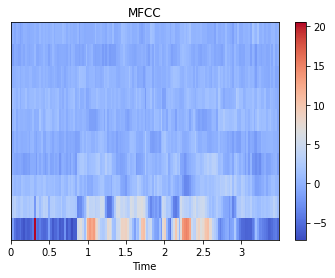

In [23]:
sanity_check_data_prefix = ["..", "data", "wavs", "wt_test"]

wav_file = os.path.join(*sanity_check_data_prefix, "change_language_to_chinese_wt.wav")
#wav_file = os.path.join(*sanity_check_data_prefix, "decrease_volume_wt.wav")
#wav_file = os.path.join(*sanity_check_data_prefix, "turn_on_the_lights_in_the_kitchen_wt.wav"

np.set_printoptions(threshold=sys.maxsize)

sample_rate, audio = wav.read(wav_file)
if DEBUG:
    print(','.join(str(e) for e in audio.tolist()[:4095]))

audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')
audio = librosa.util.fix_length(audio, 16000*3)
features = generate_features(True, audio, SAMPLING_RATE, 
                  WIN_SIZE_MS, WIN_INCREASE_MS, 32, 
                  NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

features = features['features']
X = np.expand_dims(features, axis = 0)

results = model(X, training=False)
print(np.argmax(results[0]), np.argmax(results[1][0][0]), np.argmax(results[1][0][1]))
print(f"""
Prediction
Intent:{ids2intents[np.argmax(results[0])]} 
Slot1: {ids2slots[np.argmax(results[1][0][0])]}  Slot2: {ids2slots[np.argmax(results[1][0][1])]}\n
""")

IPython.display.Audio(wav_file)

In [31]:
def representative_dataset():
    for i in range(len(test_data)):
        wav_file = os.path.join(*prefix, test_data['path'][i])
        audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')
        audio = librosa.util.fix_length(audio, 16000*3)
        features = generate_features(False, audio, SAMPLING_RATE, 
                          WIN_SIZE_MS, WIN_INCREASE_MS, 32, 
                          NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)
        
        features = features['features']
        X = np.expand_dims(features, axis = -1)
        X = np.expand_dims(X, axis = 0)
        yield [X.astype(np.float32)]

#model = tf.keras.models.load_model(model_name)
model.input.set_shape(1 + model.input.shape[1:])
            
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_type = tf.int8
converter.inference_input_type = tf.int8 
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

# Save the model.
tflite_filename = os.path.abspath(model_name).split('.')[0] + '.tflite'
with open(tflite_filename, 'wb') as f:
  f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpppp_z26q/assets


INFO:tensorflow:Assets written to: /tmp/tmpppp_z26q/assets
2021-08-24 17:43:29.248839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-24 17:43:29.249103: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-08-24 17:43:29.249199: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-08-24 17:43:29.249454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-24 17:43:29.249633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.683GHz coreCount: 15 deviceMemorySize: 7.93GiB devi

/home/ubuntu/github/Speech-to-Intent-Micro/checkpoints/2021-08-24_17-02-32/slu_model.tflite
change language
chinese
none


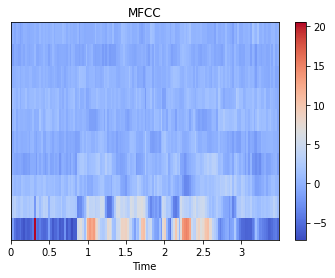

In [32]:
interpreter = tf.lite.Interpreter(model_path = tflite_filename)
interpreter.allocate_tensors()

sanity_check_data_prefix = ["..", "data", "wavs", "wt_test"]

wav_file = os.path.join(*sanity_check_data_prefix, "change_language_to_chinese_wt.wav")
#wav_file = os.path.join(*sanity_check_data_prefix, "decrease_volume_wt.wav")
#wav_file = os.path.join(*sanity_check_data_prefix, "turn_on_the_lights_in_the_kitchen_wt.wav"

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]["quantization"]
output_scale, output_zero_point = output_details[0]["quantization"]
    
audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')
audio = librosa.util.fix_length(audio, 16000*3)
features = generate_features(True, audio, SAMPLING_RATE, 
                  WIN_SIZE_MS, WIN_INCREASE_MS, 32, 
                  NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

features = features['features']

X = np.expand_dims(features, axis = -1)
X = np.expand_dims(X, axis = 0)

input_data = np.asarray(X, dtype=np.float32)

input_data_int8 = np.asarray(input_data/input_scale + input_zero_point, dtype=np.int8)

interpreter.set_tensor(input_details[0]['index'], input_data_int8)
interpreter.invoke()

output_data_intent = np.asarray(interpreter.get_tensor(output_details[0]['index']), dtype=np.float32)
output_data_slot = np.asarray(interpreter.get_tensor(output_details[1]['index']), dtype=np.float32)

intent = (output_data_intent - output_zero_point) * output_scale
slot = (output_data_slot - output_zero_point) * output_scale

if DEBUG:
    print(features)
    print(intent, "\n", slot)
    print(num, " ", test_data['transcription'][num])
    print(np.argmax(intent[0]), np.argmax(slot[0][0]), np.argmax(slot[0][1]))

print(ids2intents[np.argmax(intent[0])])
print(ids2slots[np.argmax(slot[0][0])])
print(ids2slots[np.argmax(slot[0][1])])
plt.show()

In [33]:
tfmicro_filename = tflite_filename.split('.')[0] + '.h'
!xxd -i $tflite_filename > $tfmicro_filename